# CITS5017 Deep Learning: Project 1

### Name: Peter Millitz [23088298]   Date: 13/09/2024

# CNN Modelling and Transfer Learning

## 1. Introduction

The aim of this project was to construct and train a CNN model using a small 64 x 64 pixel colour image dataset to classify pictures into 10 categories, then to retrain a pre-trained model (`MobileNetV2`) through *Transfer Learning* for the same task and to compare the performance.

The dataset was pre-split into training (2000 instances) and validation sets (500 instances) alonf with their respective integer labels. Both datasets were perfectly balanced with 200 instances per class in the training set and 50 instances of each class in the validation set and the instances were ordered in ascending order in terms of class (0-9). The training and validation sets contained data of type `uint8`, sufficient to represent pixel values in the range 0-255.  

The MobileNetV2 model, available through the `tensorflow.kera.applications` package was trained using the well known and very large ImageNet dataset containing 1000 classes. It was used as the base model for the transfer learning exercise.

## 2. Setup

In [2]:
# Load required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import time
import datetime
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf
from tensorflow.keras.models import load_model
from functools import partial
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

2025-08-28 13:38:30.030977: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 3. Load, examine and prepare the data for the CNN model

Load the data into training and validation sets using the supplied function.

In [4]:
# Use the supplied function to load the dataset

def load_data(pickle_file):
    import pickle
    with open(pickle_file, "rb") as f:
        data_set = pickle.load(f)
    return data_set[b"data"], data_set[b"labels"], data_set[b"class_names"]

# Call the function load_data to build the training and validation sets
X_train_raw, y_train_raw, class_names = load_data("train.pkl")
X_val_raw, y_val_raw, _ = load_data("val.pkl")

Examine the various components of the data set.

In [5]:
# Check the shape of all input arrays
print ('The shape of X_train_raw is:', X_train_raw.shape)
print ('The shape of y_train_raw is:', y_train_raw.shape)
print ('The shape of X_val_raw is:', X_val_raw.shape)
print ('The shape of y_val_raw is:', y_val_raw.shape)

The shape of X_train_raw is: (2000, 64, 64, 3)
The shape of y_train_raw is: (2000,)
The shape of X_val_raw is: (500, 64, 64, 3)
The shape of y_val_raw is: (500,)


In [6]:
# List the class names
print(class_names)

['albatross', 'baboon', 'centipede', 'crane', 'goldfish', 'goose', 'ladybug', 'lifeboat', 'slug', 'snail']


In [7]:
# Examine the first training set image data in more detail
np.shape(X_train_raw), X_train_raw.dtype, np.min(X_train_raw[0]), np.max(X_train_raw[0])

((2000, 64, 64, 3), dtype('uint8'), 0, 244)

In [9]:
# Examine the training labels in more detail
np.shape(y_train_raw), y_train_raw.dtype, np.min(y_train_raw), np.max(y_train_raw)

((2000,), dtype('uint8'), 0, 9)

The following code cell defines a function to shuffle the training dataset. Randomly shuffling the training set is important to ensure that the mini-batches used in the training process have a reasonable mix of the 10 classes. Shuffling the validation dataset is not generally necessary but that said, it might be beneficial to shuffle it to ensure the evaluation is not biased by any ordering of the data.

In [10]:
# Function to shuffle a training dataset and corresponding labels
def shuffle_dataset(X, y, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)

    # Combine the data and labels for shuffling
    combined = list(zip(X, y))
    np.random.shuffle(combined)

    # Separate the data and labels after shuffling
    X_shuffled, y_shuffled = zip(*combined)

    return np.array(X_shuffled), np.array(y_shuffled)

In [11]:
# Shuffle the training & validation datasets
X_train_shuffled, y_train_shuffled = shuffle_dataset(X_train_raw, y_train_raw, random_seed=42)
X_val_shuffled, y_val_shuffled = shuffle_dataset(X_val_raw, y_val_raw, random_seed=42)

In [12]:
# Scale the image values to range between 0 and 1 (used by CNN model only)
X_train_rescaled = X_train_shuffled.astype(np.float32) / 255
X_val_rescaled   = X_val_shuffled.astype(np.float32) / 255

In [13]:
# Confirm the transformation by examining the first training set image data again
np.shape(X_train_rescaled), X_train_rescaled.dtype, np.min(X_train_rescaled[0]), np.max(X_train_rescaled[0])

((2000, 64, 64, 3), dtype('float32'), 0.0, 1.0)

## 4. Visualisation: 20 randomly selected images

The function `displayImages` below was written to randomly select and display 20 images from an image dataset. It was subsequently used to display 20 images (with labels) from the training set (Figure 1) and 20 images from the validation set (Figure 2).

In [14]:
def displayImages(X, y, class_names, seed=None, supertitle=None):
    '''
    Function to randomly sample and display 20 images from an image dataset
    Args:
        X: image dataset (4D numerical array)
        y: ground truth labels (1D int array)
        class_names: list of class names (list of strings)
        seed: random number seed (int)
        supertitle: an overall title for the plot (string)
    Returns
        None
    ''' 
    if seed is not None:
        np.random.seed(seed)
        
    # Randomly sample 20 indices from the input image data array 
    sampled_indices = np.random.choice(len(X), 20, replace=False)
    
    # Initialize plot
    fig, axes = plt.subplots(4, 5, figsize=(8, 6))
    axes = axes.flatten()
    
    # Display each image
    for i, ax in enumerate(axes):
        index = sampled_indices[i]
        ax.imshow(X[index])
        ax.set_title(class_names[y[index]], fontsize=10)
        ax.axis('off')
    
    # Set the supertitle if provided
    if supertitle:
        fig.suptitle(supertitle, fontsize=14)
    
    plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjusts layout for supertitle
    plt.show()

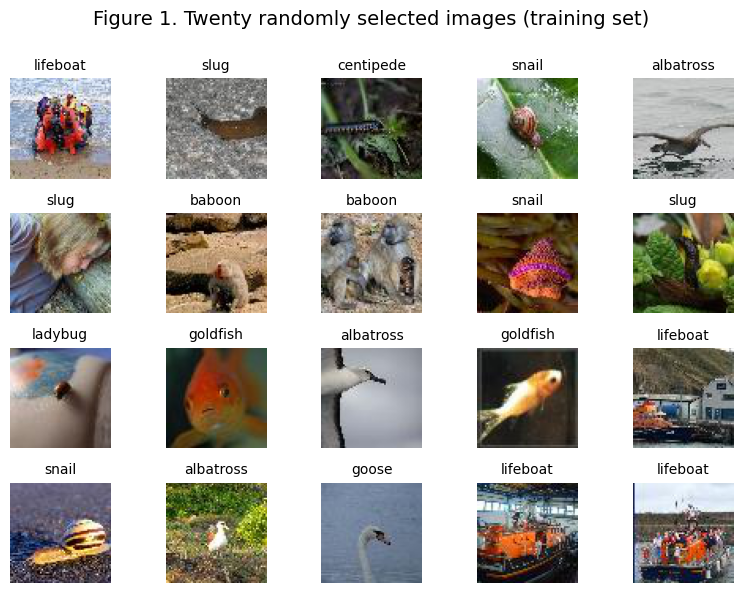

In [15]:
# Display a random selection of 20 images from the training set
displayImages(X_train_shuffled, y_train_shuffled, class_names, 42, "Figure 1. Twenty randomly selected images (training set)")

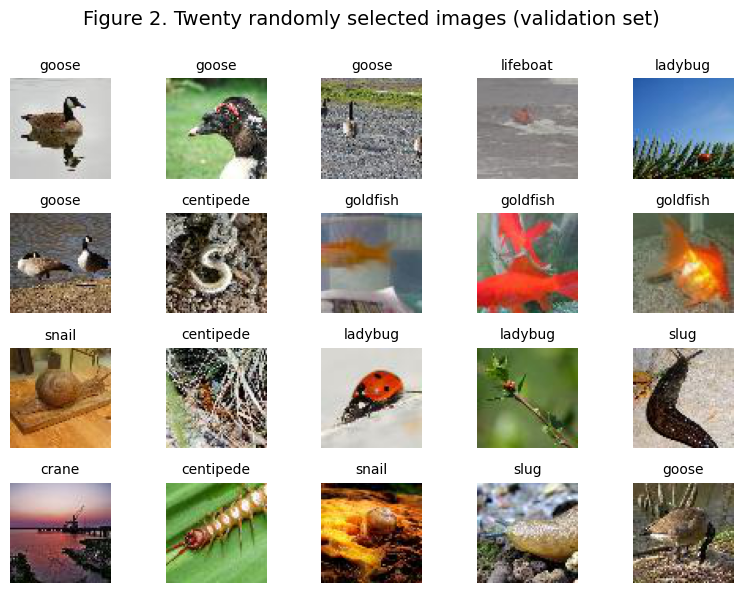

In [16]:
# Display a random selection of 20 images from the validation set
displayImages(X_val_shuffled, y_val_shuffled, class_names, 42, "Figure 2. Twenty randomly selected images (validation set)")

## 5. Design and implement a CNN model

### 5.1 CNN Model Design

Note: The word 'kernel' is used interchangeably with 'filter' throughout this notebook.

A CNN model was designed based on the model applied by Aur&eacute;lien G&eacute;ron to the Fashion MNIST dataset on page 496 of his textbook (*Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2022, 3rd ed.*) and adapted to suit the requirements of the Project 1 specification. The function `create_model`, below, implements this CNN model.

### 5.2 Hyperparameter tuning: kernel size, number of filters and dropout rate

Hyperparameter tuning code is displayed below. Beginning with `create_model`, this function builds and returns a pre-defined Sequential CNN model object configured according to a selection of input hyperparameter values. The second function, `exponential_decay`, defines an exponential decay algorithm to use later with a learning rate scheduler. The third function, `tune_hyperparameters` conducts the actual hyperparameter tuning, calling the previous two functions in the process. At each iteration, the main loop creates a new model by calling the `create_model` function using a new combination of kernel size, number of filters and dropout rate supplied by the input. The model is compiled, trained (using a learning rate scheduler) for a maximum of 100 epochs (or less if early stopping is triggered) and evaluated against the input validation data set at the end of each epoch. After training, the trained model is re-evaluated on the validation set and the validation loss compared to the lowest loss recorded. The loop terminates after all possible combinations of hyperparameter candidate values have been tested and the model with the lowest validation loss is identified as the "best model". Finally, the functions returns the best model, its parameters and validation loss and accuracy scores.

The final section contains the initiating code. Two candidate values are defined for each of the three hyperparameters and then the `tune_hyperparameters` function is invoked to start the tuning process. This configuration examines a total of eight models, exploring all possible combinations of the specified hyperparameter values. Upon completion, the validation loss and accuracy of the best model are printed, along with its parameters. Finally, the best model is saved to disk.

```python
import tensorflow as tf
import datetime

# Function to create a model
def create_model(kernel_size, num_filters, dropout_rate):
    '''
    This function returns a CNN model with a pre-defined architecture suitable for
    a multi-class classification task, configured according to the input arguments.
    Args:
        kernel_size:  the size (dimension) of the square kernel to use for each of
                      its 3 convolutional layers (int).
        num_filters:  a list of 3 integers indicating the number of filters to use
                      separately for each of the 3 convolutional layers (list of ints).
        dropout_rate: decimal nominally in the range [0.1, -0.5] used for all dropout
                      layers (float).
    Returns:
        A Sequential Convolutional Neural Net model object.
    '''
    # Set random seed
    tf.random.set_seed(22)
    
    # Reset the name counters
    tf.keras.backend.clear_session()
    
    # Setup default parameters for the convolutional layers
    DefaultConv2D = partial(tf.keras.layers.Conv2D, padding="same", 
                            activation="relu", kernel_initializer="he_normal")

    # Build the model
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=[64, 64, 3]),
        
        DefaultConv2D(num_filters[0], kernel_size),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
    
        DefaultConv2D(num_filters[1], kernel_size),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        
        DefaultConv2D(num_filters[2], kernel_size),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
    
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),
    
        tf.keras.layers.Dense(units=64, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(units=10, activation="softmax")
])
    return model

# Function to construct an exponential decay algorithm with fixed decay rate (0.1)
def exponential_decay(lr0, s):
    def exp_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exp_decay_fn

# Main hyperparameter tuning code
def tune_hyperparameters(kernal_sizes, base_num_kernels, dropout_rates,
                         X_train, y_train, X_val, y_val, create_model, epochs, log_dir): 
    '''
    This function trains a series of models based on a lists of input hyperparameter
    values. At the end of training, each model is evaluated on the basis of 
    validation loss and the model having the lowest validation loss is returned 
    along with the hyperparameter values used plus validation performance metrics.
    Args:
        kernal_sizes:     pair of candidate vales for kernel size to use for all 
                          convolutional layers (list of ints)
        base_num_kernels: pair of candidate values for number of filters to implement in
                          base convolutional layer (list of ints)
        dropout_rates:    pair of candidate values for dropout rate to use for all dropout
                          layers (list of floats)
        X_train:          the training data (array of floats)
        y_train:          the training labels (array of ints)
        X_val:            the validation data (array of floats)
        y_val:            the validation labels (array of ints)
        create_model:     name of function called to create model (string)
        epochs:           maximum number of training epochs (int)
        log_dir:          Tensorboar event log directory (string)
    Returns:
        The validation loss and accuracy of the best model, the trained best model
        object and a list containing the hyperparameter values used.
    '''
    # Initialize metrics
    best_accuracy=0
    best_loss=float('inf')
    best_model=None
    best_params=(None, None, None)
    
    batch_size=32

    # Define the learning rate schedule
    decay_steps = (epochs * math.ceil( len(X_train) / batch_size )) / 2
    my_exp_decay_fn = exponential_decay(lr0=0.001, s=decay_steps)
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(my_exp_decay_fn)

    # Define early stopping and Tensorboard callbacks
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
    tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

    # Main loop
    for kernel_size in kernal_sizes:
        for base_num_kernel in base_num_kernels:
            # number of kernels for subsequent conv2D layers is a function of number in base
            num_kernels = [base_num_kernel, base_num_kernel*2, base_num_kernel*4]
            for dropout_rate in dropout_rates:
                # Create the model with the current set of hyperparameters
                model = create_model(kernel_size, num_kernels, dropout_rate) 
                # Compile the model
                optimizer = tf.keras.optimizers.Adam()
                model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])                                                                   
                # Train the model
                history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0,
                                    callbacks=[lr_scheduler, early_stopping_cb, tensorboard_cb],
                                    validation_data=(X_val, y_val))
                # Evaluate the model
                val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0) 
                # Best model check
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_accuracy = val_accuracy
                    best_model = model
                    best_params = (kernel_size, num_kernels, dropout_rate)

    # Return the best model and its parameters
    return best_loss, best_accuracy, best_model, best_params
    
# Setup up and run the hyperparameter tuning process

# Define log directory for Tensorboard
log_dir = "hyper_" + datetime.datetime.now().strftime("run_%Y_%m_%d-%H_%M_%S")

# Define candidate values for each of the hyperparameters
kernel_sizes = [3, 5]         # assumes square filters
base_num_kernels = [32, 64]   # number of filters for base conv2D layer
dropout_rates = [0.1, 0.2]    # model uses same values for both dropout layers

# Run the hyperparameter tuning process
print("\nTuning hyperparameters...\n")
val_loss, val_accuracy, best_model, best_params = tune_hyperparameters(kernel_sizes, base_num_kernels, dropout_rates,
                                                  X_train_rescaled, y_train_shuffled, X_val_rescaled, y_val_shuffled,
                                                  create_model, 100, log_dir)

# Print the validation loss and accuracy of the best model and its parameters
print(f"Validation loss: {round(val_loss, 4)}\t\tValidation accuracy: {round(val_accuracy, 4)}")
print(f"Best parameters are: {best_params}")

# Save the best model
best_model.save("Millitz_Peter-CNN.keras")

```

##### **Hyperparameter tuning candidate values**  

The candidate values chosen for kernel size were 3 and 5. Only one dimension was required since square kernels were used for all filters in each convolutional layer of the model.

The candidate values chosen for the number of filters in the base convolutional layer were 32 and 64. Note that by design, the number of filters used by the second and third convolutional layers was a multiple of 2 and 4 of the number used in the base layer, respectively

The candidate values chosen for the dropout rate were 0.1 and 0.2. Both dropout layers in the model were designed to use the same dropout rate.

**Hyperparameter tuning results**  

The hyperparameter tuning process resulted in the best model having the following combination of hyperparameter values:
* **kernel size**: 5 x 5, for all convolutional layers)
* **Number of filters**: 64, 128 and 256, for convolution layers 1 (base), 2 and 3, respectively 
* **Dropout rate**: 0.1 (for both dropout layers)

**Additional comments**

* The best accuracies observed were in the high 50s percentage wise. Anything above 52% was considered acceptable for this task.
* The best model was judged on the lowest validation loss achieved however it was observed that the lowest validation does not always coincide with the highest accuracy.
* Base number of kernels of 64 was a very consistent result in combination with a slightly less consistent kernel size of 5. The dropout rate was the least consistent with each candidate showing up as best more or less half the time. The value of 0.1 was arbitrarily selected.

### 5.3 Model Implementation

The following code looks for the trained model saved from the hyperparameter tuning process in the current (notebook) directory. If it exists, it loads the model and displays its architecture. It recompiles the model to use a very small learning rate ($10^{-5}$) then trains the model for one epoch, evaluates the trained model against the validation set and reports the validation loss and accuracy.

Alternatively, if the model is not found, the code builds the model from scratch and displays a summary, compiles it using essentially the same arguments then trains the model for 100 epochs, replacing the fixed learning rate with an exponential decay learning rate scheduler and adding early stopping. At the end of training, it evaluates the model on the validation set and outputs various performance metrics, saves the model and displays a visualisation of the training process.

The latter in more detail:

1. If the model is not found, the code rebuilds the model *using the tuned hyperparameter values* and a model summary is displayed.

2. It then proceeds to compile the model. Since this was a multi-class classification task with class labels represented by the integers 0-9, *the sparse categorical cross-entropy* loss function was the most appropriate choice. Similarly, the most appropriate metric was accuracy, since all classes had equal rank and the dataset was balanced. The optimizer used was *Adam* (with default values), a popular optimization algorithm used in training neural networks because of its robustness and efficiency. It combines the advantages of two other optimisation techniques: AdaGrad and RMSProp. 

3. After compilation, the model is then trained for a maximum of 100 epochs using an exponential decay learning rate scheduler and early stopping, both implemented as callbacks. The model is evaluated on the validation set at the end of every epoch.

4. On completion of training, total execution time and execution time per epoch are reported. The model is re-evaluated against the validation set and the validation loss and accuracy are reported and the model is saved.

5. Finally, the learning curves for both training and validation sets are plotted for display.


Model file 'Millitz_Peter-CNN.keras' not found in the current directory.
Constructing model...



I0000 00:00:1726235176.716378  394086 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726235176.739362  394086 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726235176.739413  394086 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726235176.742922  394086 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726235176.742966  394086 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,137,994 (11.97 MB)

 Trainable params: 3,136,714 (11.97 MB)

 Non-trainable params: 1,280 (5.00 KB)

Number of layers in model = 17

Training model for maximum 100 epochs...



I0000 00:00:1726235179.048532  394183 service.cc:146] XLA service 0x7f608c015210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726235179.048563  394183 service.cc:154]   StreamExecutor device (0): NVIDIA RTX 2000 Ada Generation Laptop GPU, Compute Capability 8.9
2024-09-13 21:46:19.089047: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-13 21:46:19.305229: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1726235183.003465  394183 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training completed in 44.8385 secs (1.4012 secs/epoch)

Validation loss: 1.6828		Validation accuracy: 0.57

Model saved as "Millitz_Peter-CNN.keras"



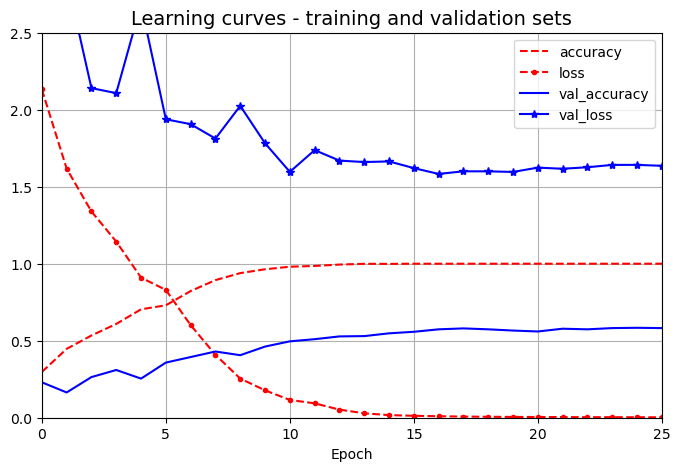

In [14]:
# Reset the name counters
tf.keras.backend.clear_session()

# Define the model file name
model_file = "Millitz_Peter-CNN.keras"

# Check if the model file exists in the current directory
if os.path.exists(model_file):
    # Load the model
    model = load_model(model_file)
    
    # Display the model architecture
    model.summary()
    
    # Display the CNN model's layer count
    print(f"Number of layers in model = {len(model.layers)}")
    
    # Re-compile the model with a new learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    # Train the model for one epoch
    print("\nTraining model for 1 epoch with learning rate=1e-5...\n")
    model.fit(X_train_rescaled, y_train_shuffled, batch_size=32, epochs=1, verbose=0,
              validation_data=(X_val_rescaled, y_val_shuffled))

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val_rescaled, y_val_shuffled, verbose=0)
    print(f"Validation loss: {round(val_loss, 4)}\t\tValidation accuracy: {round(val_accuracy, 4)}")
    
else: 
    print(f"\nModel file '{model_file}' not found in the current directory.")
    print("Constructing model...\n")

    # Best parameters from hyperparamter tuning
    kernel_size = 5
    num_filters = [64, 128, 256] 
    dropout_rate = 0.1
    
    # Set random seed
    tf.random.set_seed(22)
    
    # Reset the name counters
    tf.keras.backend.clear_session()
    
    DefaultConv2D = partial(tf.keras.layers.Conv2D, 
                            kernel_size=kernel_size,
                            padding="same",
                            activation="relu", 
                            kernel_initializer="he_normal")
    
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=[64, 64, 3]),
        
        DefaultConv2D(filters=num_filters[0]),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        
        DefaultConv2D(filters=num_filters[1]),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
            
        DefaultConv2D(filters=num_filters[2]),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=dropout_rate),
        
        tf.keras.layers.Dense(units=64, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=dropout_rate),
        tf.keras.layers.Dense(units=10, activation="softmax")
    ])

    # Display the model architecture
    model.summary()

    # Display the CNN model's layer count
    print(f"Number of layers in model = {len(model.layers)}")

    # Define log directory for Tensorboard
    log_dir = "final_" + datetime.datetime.now().strftime("run_%Y_%m_%d-%H_%M_%S")
    
    # Function to construct an exponential decay algorithm
    def exponential_decay(lr0, s):
        def exp_decay_fn(epoch):
            return lr0 * 0.1**(epoch / s)
        return exp_decay_fn
    
    # Set the batch size and number of training epochs
    batch_size=32
    epochs=100
    
    # Define the learning rate schedule
    decay_steps = (epochs * math.ceil( len(X_train_rescaled) / batch_size )) / 2
    my_exp_decay_fn = exponential_decay(lr0=0.001, s=decay_steps)
        
    # Define the learning rate scheduler, early stopping and Tensorboard callbacks
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(my_exp_decay_fn)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
    tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    
    # Compile the model
    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])                                                                   
    
    # Train the model
    print("\nTraining model for maximum 100 epochs...\n")
    t0 = time.time() # mark start time
    history = model.fit(X_train_rescaled, y_train_shuffled, batch_size=batch_size, epochs=epochs, verbose=0,
                        callbacks=[lr_scheduler, early_stopping_cb, tensorboard_cb],
                        validation_data=(X_val_rescaled, y_val_shuffled))
    t1 = time.time() # mark end time
    trng_time= t1-t0 # duration
    num_epochs = len(history.history['loss']) # extract total epochs from history
    print(f"Training completed in {round(trng_time, 4)} secs ({round(trng_time/num_epochs, 4)} secs/epoch)\n")
    
    # Evaluate the model on the validation data
    val_loss, val_accuracy = model.evaluate(X_val_rescaled, y_val_shuffled, verbose=0)
    print(f"Validation loss: {round(val_loss, 4)}\t\tValidation accuracy: {round(val_accuracy, 4)}")

    # Save the model
    model.save("Millitz_Peter-CNN.keras")
    print('\nModel saved as "Millitz_Peter-CNN.keras"\n')

    # Plot the learning curves for both training and validatian sets
    pd.DataFrame(history.history).iloc[:,:-1].plot(
    figsize=(8, 5), xlim=[0, 25], ylim=[0, 2.5], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
    plt.legend(loc="upper right"),
    plt.title("Learning curves - training and validation sets", fontsize=14)
    plt.show()
   

### 5.4 Model Evaluation

#### 5.4.1 Training set

Prediction performance metrics on training data are displayed below in the form of a confusion matrix (Figure 3) and a tabulated classification report (Table 1).

In [15]:
# Make predictions on training
y_train_proba = model.predict(X_train_rescaled, verbose=0)
y_train_pred = y_train_proba.argmax(axis=-1)

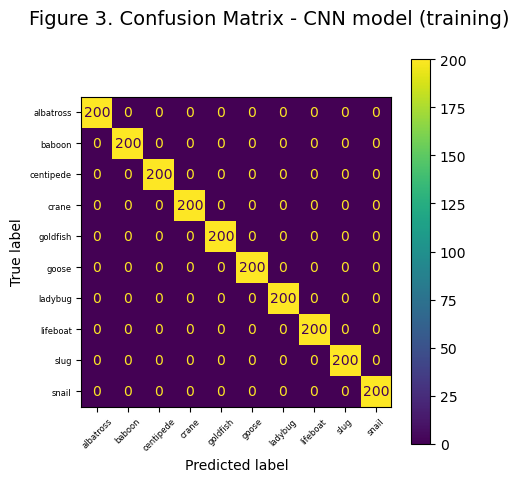

In [16]:
# Output a confusion matrix on training set
cm_train = confusion_matrix(y_train_shuffled, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=class_names)
disp.plot(colorbar=True)
fig = disp.ax_.get_figure() 
fig.set_figwidth(5)
fig.set_figheight(5)
# Set the rotation angle for x-labels
plt.xticks(rotation=45, fontsize=6)
plt.yticks(fontsize=6)
plt.suptitle("Figure 3. Confusion Matrix - CNN model (training)", fontsize=14)
plt.show()

In [17]:
# Report prediction results on training data data
print("Table 1. CNN model prediction results on training data.\n")
print(classification_report(y_train_shuffled, y_train_pred, digits=3))

Table 1. CNN model prediction results on training data.

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       200
           1      1.000     1.000     1.000       200
           2      1.000     1.000     1.000       200
           3      1.000     1.000     1.000       200
           4      1.000     1.000     1.000       200
           5      1.000     1.000     1.000       200
           6      1.000     1.000     1.000       200
           7      1.000     1.000     1.000       200
           8      1.000     1.000     1.000       200
           9      1.000     1.000     1.000       200

    accuracy                          1.000      2000
   macro avg      1.000     1.000     1.000      2000
weighted avg      1.000     1.000     1.000      2000



#### 5.4.2 Validation set

Prediction performance metrics on validation data are displayed below in the form of a confusion matrix (Figure 4) and a tabulated classification report (Table 2).

In [18]:
y_val_proba = model.predict(X_val_rescaled, verbose=0)
y_val_pred = y_val_proba.argmax(axis=-1)

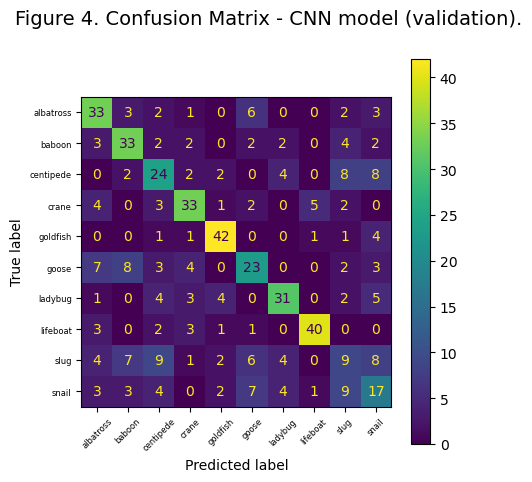

In [19]:
# Output a confusion matrix on validation set
cm_val = confusion_matrix(y_val_shuffled, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=class_names)
disp.plot(colorbar=True)
fig = disp.ax_.get_figure() 
fig.set_figwidth(5)
fig.set_figheight(5)
# Set the rotation angle for x-labels
plt.xticks(rotation=45, fontsize=6)
plt.yticks(fontsize=6)
plt.suptitle("Figure 4. Confusion Matrix - CNN model (validation).", fontsize=14)
plt.show()

In [20]:
# Report prediction results on validation data
print("Table 2. CNN model prediction results on validation data.\n")
print(classification_report(y_val_shuffled, y_val_pred, digits=3))

Table 2. CNN model prediction results on validation data.

              precision    recall  f1-score   support

           0      0.569     0.660     0.611        50
           1      0.589     0.660     0.623        50
           2      0.444     0.480     0.462        50
           3      0.660     0.660     0.660        50
           4      0.778     0.840     0.808        50
           5      0.489     0.460     0.474        50
           6      0.689     0.620     0.653        50
           7      0.851     0.800     0.825        50
           8      0.231     0.180     0.202        50
           9      0.340     0.340     0.340        50

    accuracy                          0.570       500
   macro avg      0.564     0.570     0.566       500
weighted avg      0.564     0.570     0.566       500



#### 5.4.3 Evaluation comments

All performance metrics for predictions on the training data (see Figure 3 and Table 1) returned perfect scores. In contrast however, the model returned an overall prediction accuracy on validation data of only 0.57 or 57% with macro averages for precision, recall and F1 score all around the same number (Table 2). Only two classes, 'goldfish' and 'lifeboat' class exceeded 80% accuracy (Figure 4). This discrepancy is significant and is reflected in the learning curves displayed after training the model from scratch (Section 5.3). The evidence strongly suggests that the model is overfitting the training data, meaning it has learned the data too well, including noise and outliers, but fails to generalize to unseen data. There are three possible reasons for the model's overfitting:
1. The dataset is too small for the task
2. The model is too complex
3. There is insufficient regularization

The most likely reason is an inadequately sized training set, as the model is not overly complex by CNN standards and there are probably enough regularization layers (5 batch normalization layers and 2 dropout layers) without causing too much training instability. The classification task is quite challenging given the similarity of some classes e.g. 'slugs', 'snails', 'centipedes' and even 'goose', share one or more morphological characteristics. Indeed, the confusion matrix (Figure 4) does show in this instance that the model struggles in accurately predicting all four of these classes. Significantly increasing the amount of labelled training data and/or using data augmentation would likely enhance the model's ability to discriminate between these classes.

#### 5.4.4 Visualisation: image predictions

The `displayImages` function defined in Section 4 was modified to accept a predictions array as an extra argument and logic to filter, concatenate and sample the image indices of correct and incorrect predictions was added. Formatting of the display was adjusted to accomodate the extra labelling. The modified function was renamed `displayImages2` and is listed below:

In [21]:
def displayImages2(X, y, y_pred, class_names, seed=None, supertitle=None):
    '''
    Function to display 10 randomly sampled correctly predicted images and
    10 randomly sampled incorrectly predicted images from the validation set.
    Args:
        X: validation set (4D float array)
        y: ground truth labels (1D int array)
        y_pred: model class predications (1D int array)
        class_names: list of class names (list)
        seed: random number seed (int)
        supertitle: an overall title for the plot (string)
    Returns
        None
    ''' 
    if seed is not None:
        np.random.seed(seed)
    
    # Find correct and incorrect indices
    correct_indices = np.where(y == y_pred)[0]
    incorrect_indices = np.where(y != y_pred)[0]
    
    # Randomly sample 10 correct and 10 incorrect examples
    sampled_correct_indices = np.random.choice(correct_indices, 10, replace=False)
    sampled_incorrect_indices = np.random.choice(incorrect_indices, 10, replace=False)
    
    # Concantenate indices of correct and incorrect examples
    sampled_indices = np.concatenate([sampled_correct_indices, sampled_incorrect_indices])
    
    # Initialize plot
    fig, axes = plt.subplots(4, 5, figsize=(12, 8))  # 4x5 grid, 20 images
    axes = axes.flatten()
    
    # Display each image with actual & predicted labels
    for i, ax in enumerate(axes):
        index = sampled_indices[i]
        ax.imshow(X[index])  # Display the image
        
        true_class = class_names[y[index]]
        pred_class = class_names[y_pred[index]]
        
        ax.set_title(f"Actual: {true_class}\nPredicted: {pred_class}", fontsize=8)
        ax.axis('off')  # Hide axes
    
    # Set the supertitle if provided
    if supertitle:
        fig.suptitle(supertitle, fontsize=14)
    
    plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout for supertitle
    plt.show()

The following code cell calls `displayImages2` to select and display 10 examples of images from the validation set where the CNN model made correct predictions and another 10 examples where it did not. The results are displayed in Figure 5 below.

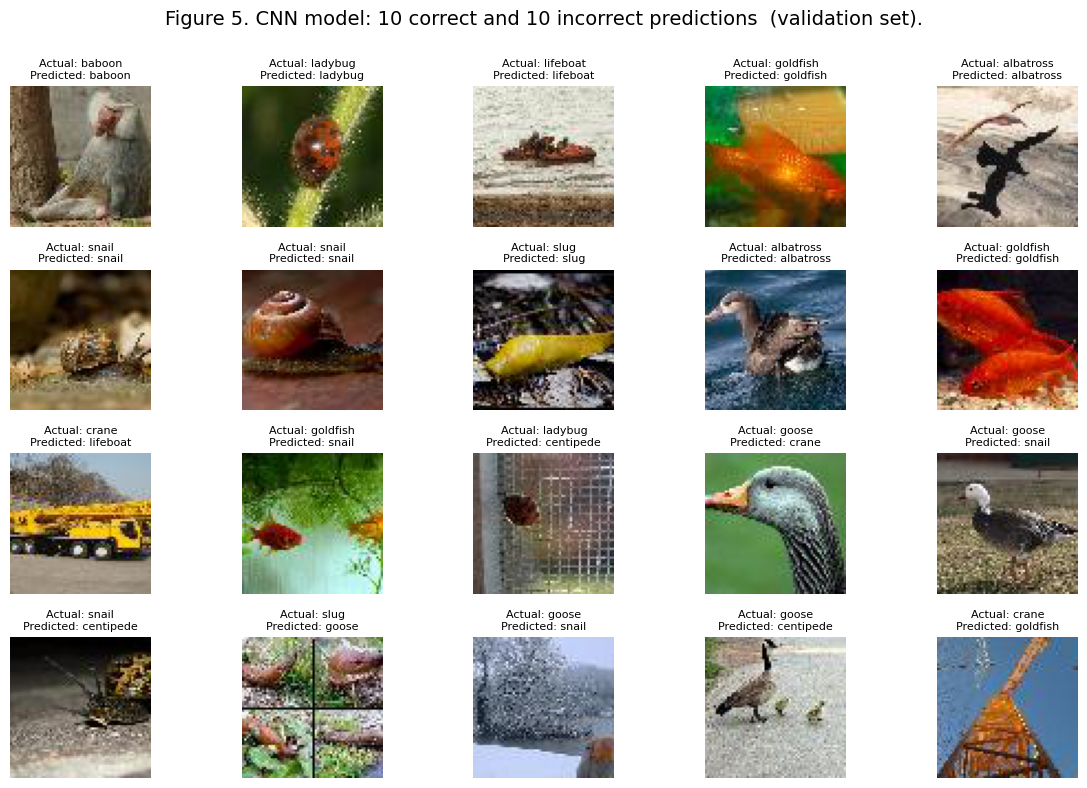

In [22]:
# Display 10 Correct and 10 Incorrect Predictions from the validation set
displayImages2(X_val_shuffled, y_val_shuffled, y_val_pred, class_names, seed=42,
               supertitle="Figure 5. CNN model: 10 correct and 10 incorrect predictions  (validation set).")

## 6. Transfer Learning using MobilNetV2

### 6.1 Preprocess the training and validation sets

The datasets used in this section start with the *shuffled* versions of the raw training and validation sets i.e. **X_train_shuffled** and **X_val_shuffled** and their respective labels.

In [23]:
# Convert the shuffled training and validation sets to Tensorflow tensor datasets
train_set_raw = tf.data.Dataset.from_tensor_slices((X_train_shuffled, y_train_shuffled))
valid_set_raw = tf.data.Dataset.from_tensor_slices((X_val_shuffled, y_val_shuffled))

In [24]:
# Inspect training set tensor 
train_set_raw

<_TensorSliceDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>

In [25]:
# Inspect validation set tensor
valid_set_raw

<_TensorSliceDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>

In [26]:
# Pre-process the training and validation sets.
# Input images are re-sized and cropped and pixel
# values are scaled between -1 and 1, sample-wise.

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=96, width=96, crop_to_aspect_ratio=True),   # re-sizes input images
    tf.keras.layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input) # re-scales pixel values
])

train_set = train_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

In [27]:
# Inspect processed training set tensor 
train_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>

In [28]:
# Inspect processed validation set tensor 
valid_set

<_BatchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>

### 6.2 Load the MobileNetV2 model

Load the full MobileNetV2 model and inspect the layers.

In [29]:
# Reset the name counters
tf.keras.backend.clear_session()

# load the complete MobileNetV2 model
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=(96, 96, 3), weights="imagenet", include_top=True)

In [30]:
# Determine the number of layers in the MobilNetV2 model
layers=mobilenetv2.layers
total_layers = len(layers)
print(f"Total number of layers in the MobiNetV2 model is: {total_layers}")

Total number of layers in the MobiNetV2 model is: 156


In [31]:
# Print a list of all 156 layers of the full MobilNetV2 model

# Specify layers/column and number of columns
lines_per_column = 52
num_columns = 3

# Loop through the layers in steps of the number of columns
for i in range(0, lines_per_column):
    # Prepare to print each row in the five columns
    row = []
    
    # Collect layers for the current row across the columns
    for col in range(num_columns):
        index = i + col * lines_per_column
        layer_name = layers[index].name if index < total_layers else ""
        row.append(f"{layer_name:<40}")
    
    # Print row with all columns
    print("".join(row))


input_layer                             block_5_project_BN                      block_11_project                        
Conv1                                   block_5_add                             block_11_project_BN                     
bn_Conv1                                block_6_expand                          block_11_add                            
Conv1_relu                              block_6_expand_BN                       block_12_expand                         
expanded_conv_depthwise                 block_6_expand_relu                     block_12_expand_BN                      
expanded_conv_depthwise_BN              block_6_pad                             block_12_expand_relu                    
expanded_conv_depthwise_relu            block_6_depthwise                       block_12_depthwise                      
expanded_conv_project                   block_6_depthwise_BN                    block_12_depthwise_BN                   
expanded_conv_project_BN        

### 6.3 Create a new model based on MobilNetV2

Create a new model based on MobileNetV2 by replacing the existing output layer.

In [32]:
# Reset the name counters
tf.keras.backend.clear_session()

# Remove just the output layer. Retains the penultimate
# global average 2D pooling layer in the original model.
base_model = tf.keras.Model(inputs=mobilenetv2.input, outputs=mobilenetv2.layers[-2].output)

In [33]:
# Create the new model and call it 'model2'.

# Reset the name counters
tf.keras.backend.clear_session()

# Add a dense output layer atop the base_model
output = tf.keras.layers.Dense(len(class_names), activation="softmax")(base_model.output)

# Set random seed
tf.random.set_seed(22)

# Create the new model
model2 = tf.keras.Model(inputs=base_model.input, outputs=output)

In [34]:
# Check the number of layers in the new model
len(model2.layers)

156

In [35]:
# Display the first 5 layers of the new model
model2.summary(line_length=100, layer_range=(['input_layer', 'expanded_conv_depthwise$']))

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 96, 96, 3)       │              0 │ -                       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ Conv1 (Conv2D)              │ (None, 48, 48, 32)      │            864 │ input_layer[0][0]       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ bn_Conv1                    │ (None, 48, 48, 32)      │            128 │ Conv1[0][0]             │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ Conv1_relu (ReLU)           │ (None, 48, 48, 32)      │              0 │ bn_Conv1[0][0]          │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ expanded_conv_depthwise     │ (None, 48, 48, 32)      │            288 │ Conv1_relu[0][0]        │
│ (DepthwiseConv2D)           │                         │                │                         │
└─────────────────────────────┴─────────────────────────┴────────────────┴─────────────────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 2,236,682 (8.53 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [36]:
# Display the last 5 layers of the new model
model2.summary(line_length=100, layer_range=('Conv_1', 'dense'))

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Conv_1 (Conv2D)             │ (None, 3, 3, 1280)      │        409,600 │ block_16_project_BN[0]… │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ Conv_1_bn                   │ (None, 3, 3, 1280)      │          5,120 │ Conv_1[0][0]            │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ out_relu (ReLU)             │ (None, 3, 3, 1280)      │              0 │ Conv_1_bn[0][0]         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ global_average_pooling2d    │ (None, 1280)            │              0 │ out_relu[0][0]          │
│ (GlobalAveragePooling2D)    │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ dense (Dense)               │ (None, 10)              │         12,810 │ global_average_pooling… │
└─────────────────────────────┴─────────────────────────┴────────────────┴─────────────────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 2,236,682 (8.53 MB)

 Non-trainable params: 34,112 (133.25 KB)

### 6.4 Train the new model

In [37]:
# Freeze the pre-trained layers
for layer in model2.layers[:-1]:
    layer.trainable = False

In [38]:
# Compile and train the modelfor a few epochs
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model2.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print("\nTraining for 3 epochs with learning rate=0.01...\n")
history2 = model2.fit(train_set, validation_data=valid_set, epochs=3, verbose=0)


Training for 3 epochs with learning rate=0.01...



2024-09-13 21:47:09.465979: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1312', 20 bytes spill stores, 20 bytes spill loads

2024-09-13 21:47:09.493976: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1312', 240 bytes spill stores, 240 bytes spill loads

2024-09-13 21:47:14.365760: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1312', 20 bytes spill stores, 20 bytes spill loads

2024-09-13 21:47:20.648769: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1165', 4 bytes spill stores, 4 bytes spill loads

2024-09-13 21:47:20.703159: I external/local_xla/xla/stream_

In [39]:
# Unfreeze layers from layer 90 up inclusive
for layer in model2.layers[90:]:
    layer.trainable = True

In [40]:
# Train model for another 30 epochs
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model2.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print("\nTraining for 30 epochs with learning rate=0.001...\n")
t0 = time.time() # mark start time
history2 = model2.fit(train_set, validation_data=valid_set, verbose=0, epochs=30)
t1 = time.time() # mark end time
trng_time= t1-t0 # duration
num_epochs = len(history2.history['loss']) # extract total epochs from history
print(f"Training completed in {round(trng_time, 4)} secs ({round(trng_time/num_epochs, 4)} secs/epoch)\n")

# Evaluate the model on the validation data
val_loss, val_accuracy = model2.evaluate(valid_set, verbose=0)
print(f"Validation loss: {round(val_loss, 4)}\t\tValidation accuracy: {round(val_accuracy, 4)}")


Training for 30 epochs with learning rate=0.001...

Training completed in 42.3601 secs (1.412 secs/epoch)

Validation loss: 0.3564		Validation accuracy: 0.876


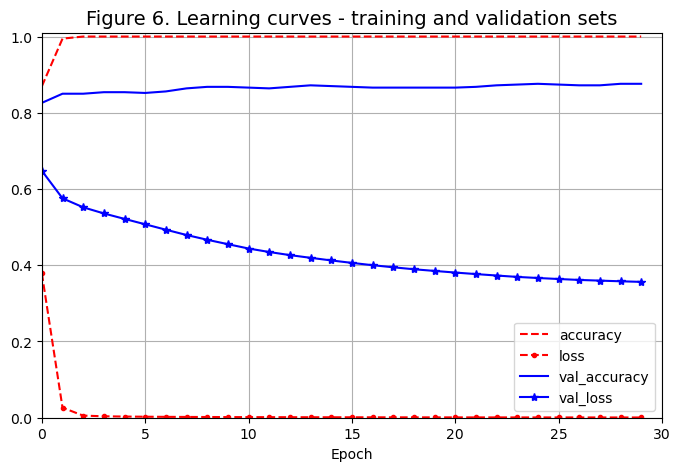

In [41]:
    # Plot the learning curves for both training and validatian sets
    pd.DataFrame(history2.history).plot(
    figsize=(8, 5), xlim=[0, 30], ylim=[0, 1.01], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
    plt.legend(loc="lower right"),
    plt.title("Figure 6. Learning curves - training and validation sets", fontsize=14)
    plt.show()

In [42]:
# Save the model
model2.save("Millitz_Peter-MobileNetV2.keras")

### 6.5 Model Evaluation

#### 6.5.1 Training set

Prediction performance metrics on training data are displayed below in the form of a confusion matrix (Figure 7) and a tabulated classification report (Table 3).

In [43]:
# Make predictions on training
y_train_set_proba = model2.predict(train_set, verbose=0)
y_train_set_pred = y_train_set_proba.argmax(axis=-1)

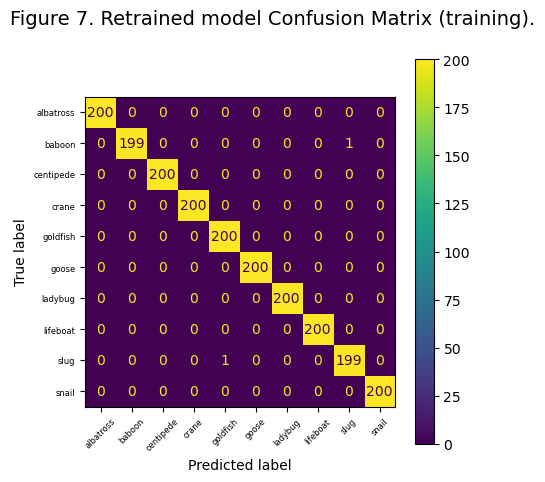

In [44]:
# Output a confusion matrix on training set
cm_train_set = confusion_matrix(y_train_shuffled, y_train_set_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train_set, display_labels=class_names)
disp.plot(colorbar=True)
fig = disp.ax_.get_figure() 
fig.set_figwidth(5)
fig.set_figheight(5)
# Set the rotation angle for x-labels
plt.xticks(rotation=45, fontsize=6)
plt.yticks(fontsize=6)
plt.suptitle("Figure 7. Retrained model Confusion Matrix (training).", fontsize=14)
plt.show()

In [45]:
# Report prediction results on training data
print("Table 3. Retrained MobilNetV2 model prediction results on training data.\n")
print(classification_report(y_train_shuffled, y_train_set_pred, digits=3))

Table 3. Retrained MobilNetV2 model prediction results on training data.

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       200
           1      1.000     0.995     0.997       200
           2      1.000     1.000     1.000       200
           3      1.000     1.000     1.000       200
           4      0.995     1.000     0.998       200
           5      1.000     1.000     1.000       200
           6      1.000     1.000     1.000       200
           7      1.000     1.000     1.000       200
           8      0.995     0.995     0.995       200
           9      1.000     1.000     1.000       200

    accuracy                          0.999      2000
   macro avg      0.999     0.999     0.999      2000
weighted avg      0.999     0.999     0.999      2000



#### 6.5.2 Validation set

Prediction performance metrics on validation data are displayed below in the form of a confusion matrix (Figure 8) and a tabulated classification report (Table 4).

In [46]:
y_valid_set_proba = model2.predict(valid_set, verbose=0)
y_valid_set_pred = y_valid_set_proba.argmax(axis=-1)

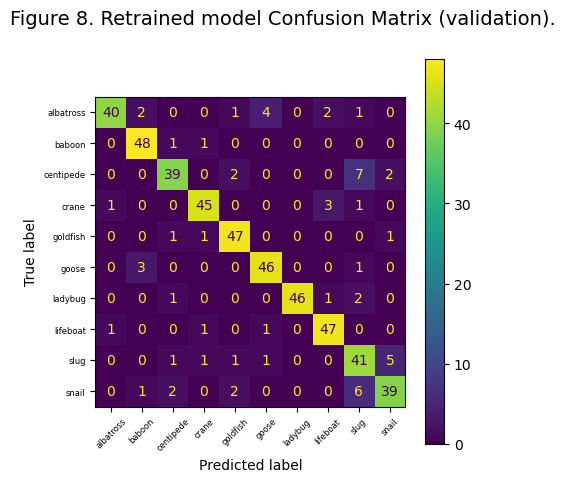

In [47]:
# Output a confusion matrix on training set
cm_valid_set = confusion_matrix(y_val_shuffled, y_valid_set_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_valid_set, display_labels=class_names)
disp.plot(colorbar=True)
fig = disp.ax_.get_figure() 
fig.set_figwidth(5)
fig.set_figheight(5)
# Set the rotation angle for x-labels
plt.xticks(rotation=45, fontsize=6)
plt.yticks(fontsize=6)
plt.suptitle("Figure 8. Retrained model Confusion Matrix (validation).", fontsize=14)
plt.show()

In [48]:
# Report prediction results on validation data
print("Table 4. Retrained MobilNetV2 model prediction results on validation data.\n")
print(classification_report(y_val_shuffled, y_valid_set_pred, digits=3))

Table 4. Retrained MobilNetV2 model prediction results on validation data.

              precision    recall  f1-score   support

           0      0.952     0.800     0.870        50
           1      0.889     0.960     0.923        50
           2      0.867     0.780     0.821        50
           3      0.918     0.900     0.909        50
           4      0.887     0.940     0.913        50
           5      0.885     0.920     0.902        50
           6      1.000     0.920     0.958        50
           7      0.887     0.940     0.913        50
           8      0.695     0.820     0.752        50
           9      0.830     0.780     0.804        50

    accuracy                          0.876       500
   macro avg      0.881     0.876     0.876       500
weighted avg      0.881     0.876     0.876       500



#### 6.5.3 Evaluation comments

The learning curve plot (Figure 6) shows the training accuracy sharply rise soon after commencement of training, saturating at 100%. Commensurate with accuracy, the training loss too drops sharply soon after the start, levelling off very close to zero. The confusion matrix for predictions on training (Figure 7) shows near perfect scores for each class (only 1 instance of 'baboon' and 1 instance of '**slug**' is misclassified), as do all the other performance metrics on training displayed in Table 3.

The learning curve for validation accuracy in Figure 6 displays a more gradual, steadier rise starting from a high base, continuing to rise slowly, reaching just under 90% after 30 epochs. The validation loss shows a smooth continuous descent finishing well under 0.4 and with a very slow abatement in its continued downward trajectory. Overall prediction accuracy on validation data shown in Table 4 was slightly under 0.88 or 88% and macro averages for precision, recall and F1 score all hovering close to the same figure. The confusion matrix (Figure 8) shows that the best and worst predictions in terms of accuracy were 'baboon' (0.96) and 'snail' equal with '**centipede**' (0.78) respectively while in Table 4, we see that best and worst on the basis of F1 score were 'ladybug' (0.96) and 'slug' (0.75) respectively.

#### 6.5.4 Visualisation: image predictions

The following code cell calls `displayImages2` to select and display 10 examples of images from the validation set where the retrained model made correct predictions and another 10 examples where it did not. The results are displayed in Figure 9 below.

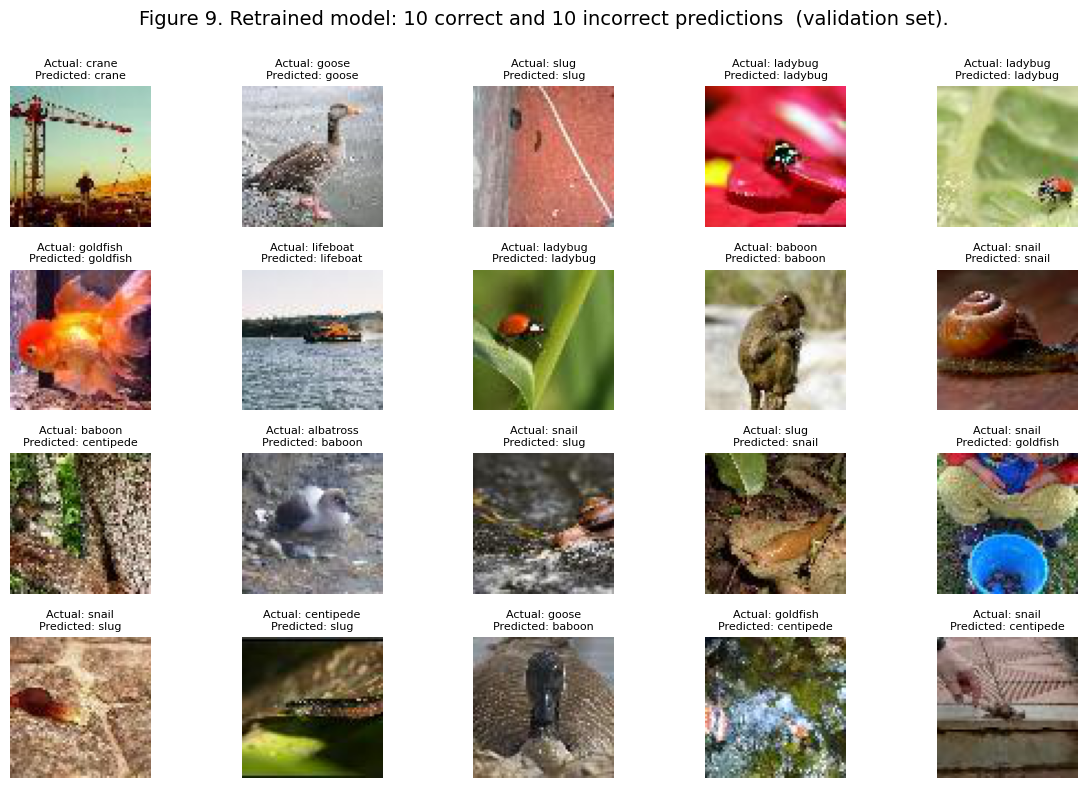

In [49]:
# Display 10 Correct and 10 Incorrect Predictions from the validation set
displayImages2(X_val_shuffled, y_val_shuffled, y_valid_set_pred, class_names, seed=42,
               supertitle="Figure 9. Retrained model: 10 correct and 10 incorrect predictions  (validation set).")

## 7. Model performance comparisons

### 7.1 Performance summary

#### 7.1.1 Training

Comparing the confusion matrices and classification report tables for training predictions produced for the CNN model and the retrained MobilNetV2 model (Section **5.4.1**, Figure 3 and Table 1 and Section 6.5.1, Figure 7 and Tables 3 respectively), it was observed that they returned perfect or near-perfect scores on all metrics (precision, recall, F1 score and accuracy), however, for different reasons.

The CNN model scored perfect in training likely because the model was overfitting the data, as was discussed in Section **5.4.3**. This can be readily observed from the learning curve plot in Section 5.3 (*Note: if plot isn't displayed, run the code to re-build model from scratch*). The plot displays a considerable gap between respective training and validation accuracy and loss curves. The underlying cause, as was suggested in Section **5.4.3**, was the insufficient amount of training data to train the CNN model for this particular classification task.

The retrained MobileNetV2 model's near-perfect score was more to do with the fact that it is based on a high performance model, and not to overfitting. The learning curves of the retrained model (Section 6.4, Figure 6) show some evidence of a gap but the gap is substantially smaller. For example, the gap between the training and validation loss curves is roughly a one quarter to one fifth the size (in absolute terms) compared with the CNN model. Furthermore, a closer look at the validation loss curve for the retrained model suggests that learning had not yet plateaued but rather, had slowed but was still in the descent, implying the likelihood of further improvement if training had continued. There may still be a small component of overfitting but it's not for lack of training data. The MobilNetV2 model was trained on the ImageNet dataset which has over 1.2 million images and 1000 classes including all 10 image classes used for this project, so it is not surprising to see the retrained model perform so well through transfer learning. On the other hand, if there were a genuine degree of overfitting, it would be likely due to the model's complexity. If that were the case, it could be alleviated with further training epochs or even some additional tweaking of the model layers.

#### 7.1.2 Validation

The contrast in validation set performance between the CNN model (ref. Section 5.4.2, Figure 4 and Table 2) and the retrained model (ref. Section 6.5.2, Figure 8 and Table 4) was significant. Overall accuracy of the CNN model was only 57% compared with 88% for the retrained model. The macro averages of precision, recall and F1 for the CNN model were all in the range 56-57% while those for the trained model were all around 87-88%. The accuracy range for the CNN model (18-84%) was more than triple that of retrained model (78-96%). Clearly, the retrained model outperformed the CNN model on every metric.

### 7.2 Model complexities

Model complexity was another factor which could account for model performance. A more complex model is, as a rule, more capable of dealing with more complex tasks. The complexity of the two models here is vastly different in terms of the number and type of layers. To illustrate, the CNN has just 17 layers compared to the retrained model's 156 and of those, the CNN has just three conv2D layers compared to the retrained model's 35 - plus another 17 'depthwise' conv2d layers. Interestingly, the retrained MobileNetv2 has fewer trainable parameters, at just over 2.2 million (2,236,682), compared to the CNN which has just over 3.1 million (3,136,714). This indicates, if nothing else, greater efficiency in model design leading to greater performance.

### 7.3 Execution times

Table 5 below shows the individual execution times for both models over 5 runs and the average over 5 runs. The CNN model uses early stopping, hence the number of epochs per run is variable while the retrained model is trained over a fixed number of epochs (30). The average execution time per epoch is slightly shorter for the retrained model (1.2589 secs/epoch) compared with the CNN model (1.2880 secs/epoch). Note that the former does not include a 3-epoch warmup.

Table 5: Model execution times comparison.

|      |   CNN  |            |             |         Retrained*        |            |             |
|:----:|:------:|:----------:|:-----------:|:-------------------------:|:----------:|:-----------:|
|  run | epochs | exec. time | secs/epoch  |           epochs          | exec. time | secs/epoch  |
|   1  |   23   |   30.3895  |    1.3213   |            30             |   36.2373  |    1.2079   |
|   2  |   26   |   33.4272  |    1.2857   |            30             |   37.7346  |    1.2578   |
|   3  |   23   |   30.1666  |    1.3116   |            30             |   38.2465  |    1.2749   |
|   4  |   32   |   40.3117  |    1.2597   |            30             |   38.0083  |    1.2669   |
|   5  |   36   |   45.4267  |    1.2619   |            30             |   38.6100  |    1.2870   |
| avg. |   28   |   35.9443  |  **1.2880** |            30             |   37.7673  |  **1.2589** |
|      |        |            |             | * excludes 3-epoch warmup |            |             |

### 7.4 Visualisation: comparing model predictions

The `displayImages3` function was written to randomly select and display ten example images from the validation set to visually compare the CNN and retrained model predictions. The function considers four separate scenarios:  

* Both models correctly classify the sample images;  
* Both models incorrectly classify the sample images;   
* The CNN model classifies the sample images correctly but the retrained MobileNetV2 model does not;  
* The retrained MobileNetV2 model classifies the sample images correctly but the CNN model does not.  

The function code retains components from both `displayImages` and `displayImages2` including the element of random selection but takes one extra argument compared to `displayImages2` in order to accept a second predictions array while the supertitle argument has been dropped. The logic has also become more complex in order to accommodate the extra scenarios and plotting structure.

In [50]:
def displayImages3(X, y, y_pred_A, y_pred_B, class_names, seed=None):
    '''
    Function to display 10 example images from the validation set comparing
    the CNN model and the retrained model under 4 different scenarios: 
        1. Both models correctly classified; 
        2. Both models incorrectly classified; 
        3. CNN correct, retrained incorrect
        4. CNN incorrect, Retrained correct
    Args:
        X: validation set (4D float array)
        y: ground truth labels (1D int array)
        y_pred_A: CNN model class predications (1D int array)
        y_pred_B: Retrained model class predicitons (1D int array)
        class_names: list of class names (list)
        seed: random number seed (int)
        supertitle: an overall title for the plot (string)
    Returns
        None
    ''' 

    if seed is not None:
        np.random.seed(seed)
    
    # Find indices for the four different cases
    correct_A   = np.where(y == y_pred_A)[0]
    correct_B   = np.where(y == y_pred_B)[0]
    incorrect_A = np.where(y != y_pred_A)[0]
    incorrect_B = np.where(y != y_pred_B)[0]

    # Get indices for each scenario
    case_1_indices = np.intersect1d(correct_A,   correct_B)   # both correct
    case_2_indices = np.intersect1d(incorrect_A, incorrect_B) # both incorrect
    case_3_indices = np.intersect1d(correct_A,   incorrect_B) # A correct, B incorrect
    case_4_indices = np.intersect1d(correct_B,   incorrect_A) # B correct, A incorrect
    
    # Function to accomodate subplots for a specific case
    def plot_case(case_indices, case_name, num_samples=10):
        if len(case_indices) > 0:
            sampled_indices = np.random.choice(case_indices, min(num_samples,
                                               len(case_indices)), replace=False)
            
            fig, axes = plt.subplots(2, 5, figsize=(8, 4))  # 2x5 grid
            axes = axes.flatten()
            
            for i, ax in enumerate(axes):
                if i >= len(sampled_indices):
                    break
                index = sampled_indices[i]
                ax.imshow(X[index])  # Display the image
                
                true_class = class_names[y[index]]
                pred_class_A = class_names[y_pred_A[index]]
                pred_class_B = class_names[y_pred_B[index]]
                
                ax.set_title(f"Actual: {true_class}\nC: {pred_class_A} | R: {pred_class_B}", fontsize=8)
                ax.axis('off')  # Hide axes
            
            fig.suptitle(case_name, fontsize=14)
            plt.subplots_adjust(hspace=1.5, wspace=0.6)  # spacing b/n rows & columns
            plt.tight_layout(rect=[0, 0, 1, 1])  # adjust layout for supertitle
            plt.show()
        else:
            print(f"No examples found for case: {case_name}")

    # Display images for each case
    print("\nFigure 10. Visual comparison of classification predictions by the two models: 10 example images for 4 different scenarios.\n")
    plot_case(case_1_indices, "Both models correct (C: CNN; R: Retrained)", num_samples=10)
    plot_case(case_2_indices, "Both models incorrect (C: CNN; R: Retrained)", num_samples=10)
    plot_case(case_3_indices, "CNN correct, Retrained incorrect (C: CNN; R: Retrained)", num_samples=10)
    plot_case(case_4_indices, "CNN incorrect, Retrained correct (C: CNN; R: Retrained)", num_samples=10)
    plt.show()

The following code cell calls `displayImages3` to select and display 10 examples of images from the validation set and the corresponding predicted labels output by the CNN model and the retrained model for each of 4 different scenarios. The results are displayed in Figure 10 below.


Figure 10. Visual comparison of classification predictions by the two models: 10 example images for 4 different scenarios.



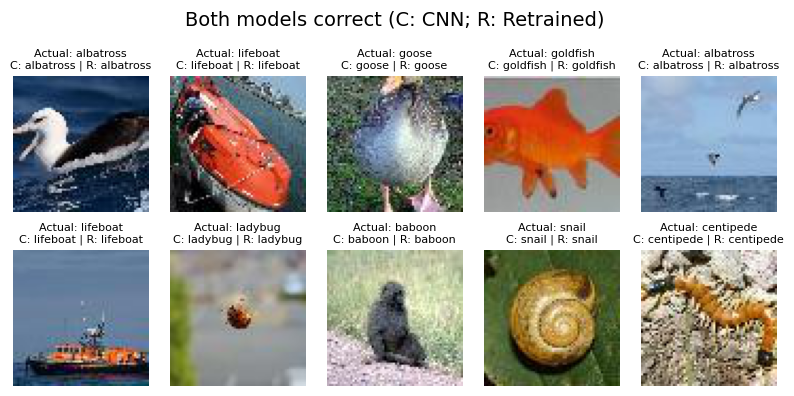

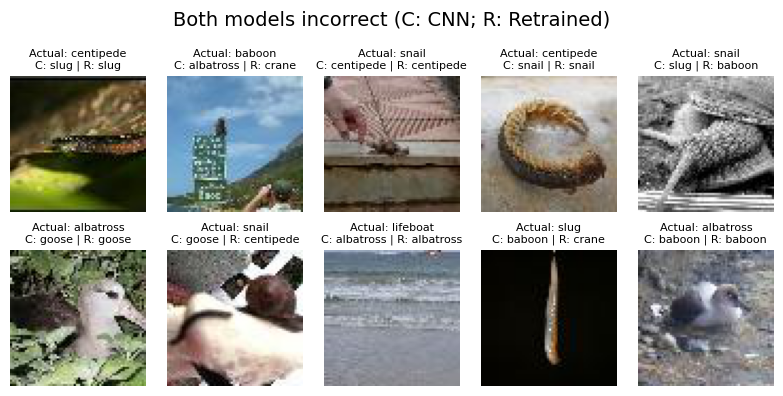

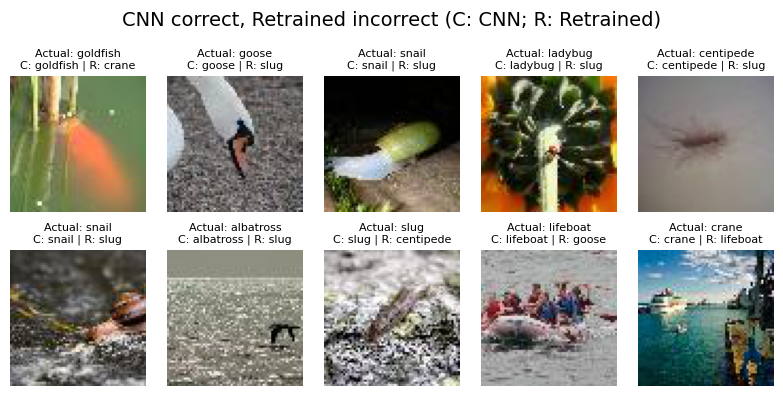

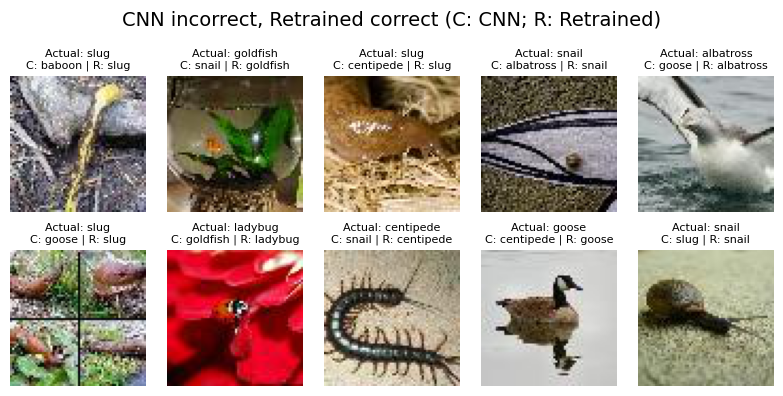

In [51]:
# Display 10 examples of images from the validation set comparing the models under 4 different scenarios
displayImages3(X_val_shuffled, y_val_shuffled, y_val_pred, y_valid_set_pred, class_names, seed=42)                         